In [1]:
import pandas as pd
import numpy as np
import chess
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch

Load in the data:

In [2]:
file_path = 'chessData.csv'
data = pd.read_csv(file_path)
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12958035 entries, 0 to 12958034
Data columns (total 2 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   FEN         object
 1   Evaluation  object
dtypes: object(2)
memory usage: 197.7+ MB
None


,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26


### Data Exploration

In [3]:
print("Missing vals per column:\n", data.isnull().sum())


Missing vals per column:
 FEN           0
Evaluation    0
dtype: int64


In [4]:
# Remove outliers beyond a threshold
# this code: keep only evaluations within ±5000 centipawns. maybe double check where we should cut off outliers
# data = data[(data['Evaluation'] > -5000) & (data['Evaluation'] < 5000)]

In [5]:
data['Evaluation'] = pd.to_numeric(data['Evaluation'], errors='coerce')

max_eval = data['Evaluation'].max()
min_eval = data['Evaluation'].min()

print(f"Maximum Evaluation: {max_eval}")
print(f"Minimum Evaluation: {min_eval}")

Maximum Evaluation: 15319.0
Minimum Evaluation: -15312.0


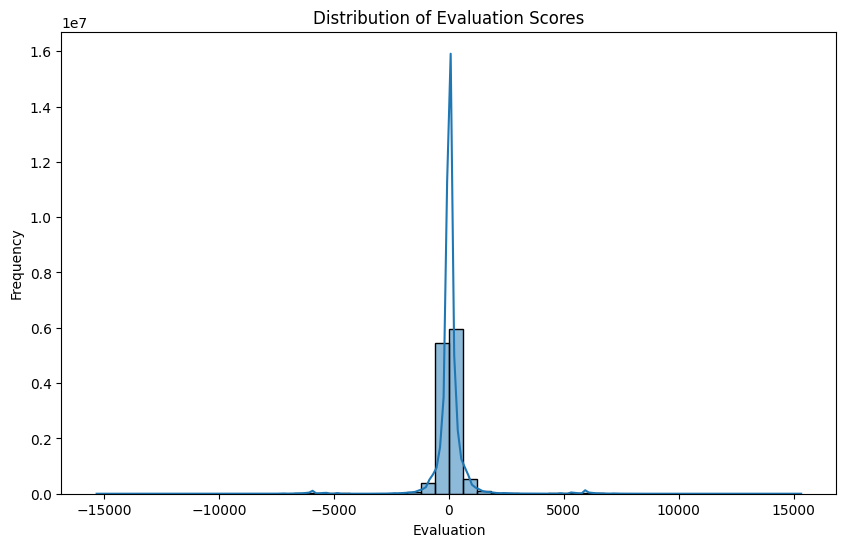

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Evaluation'], bins=50, kde=True)
plt.xlabel('Evaluation')
plt.ylabel('Frequency')
plt.title('Distribution of Evaluation Scores')
plt.show()

In [7]:
non_numeric_values = data[pd.to_numeric(data['Evaluation'], errors='coerce').isna()]
print("Non-numeric values in Evaluation column:")
print(non_numeric_values[['Evaluation']])

Non-numeric values in Evaluation column:
          Evaluation
59               NaN
60               NaN
61               NaN
62               NaN
1440             NaN
...              ...
12957453         NaN
12957454         NaN
12957551         NaN
12957552         NaN
12957780         NaN

[190154 rows x 1 columns]


### Data Cleaning

In [8]:
# # means forced checkmate, could replace them with a really high positive score?:

# Replace '#+X' with a large positive value and '#-X' with a large negative value
data['Evaluation'] = data['Evaluation'].replace(
    {r'^\#\+.*': '10000', r'^\#\-.*': '-10000'}, regex=True
)


In [9]:
# Drop NaN values
data.dropna(inplace=True)

non_numeric_values = data[pd.to_numeric(data['Evaluation'], errors='coerce').isna()]
print("Non-numeric values in Evaluation column:")
print(non_numeric_values[['Evaluation']])

Non-numeric values in Evaluation column:
Empty DataFrame
Columns: [Evaluation]
Index: []


In [10]:
# train test split 

train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)


In [11]:
import torch.nn as nn
import torch.optim as optim
# ! pip install torchvision
import torchvision
from torchvision import transforms
from itertools import islice
from torch.utils.data import DataLoader
from FEN_to_vector import to_vector
from torch.utils.data import Dataset

In [12]:
class ChessDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): The DataFrame containing the FEN strings and target evaluations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the FEN string and target evaluation
        fen = self.dataframe.iloc[idx]['FEN']
        evaluation = self.dataframe.iloc[idx]['Evaluation']

        # Use the 790-dimensional vector from FEN_to_vector
        board_vector = to_vector(fen)

        # Convert FEN to tensor (already in vector form)
        board_tensor = torch.tensor(board_vector, dtype=torch.float32)

        return board_tensor, torch.tensor(float(evaluation), dtype=torch.float32)


In [13]:
# # Create datasets
# train_dataset = ChessDataset(train_data)
# val_dataset = ChessDataset(val_data)
# test_dataset = ChessDataset(test_data)

# # Create data loaders
# batch = 32
# train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)


In [14]:
portioned_train_data = train_data.sample(frac=0.4, random_state=42)
portioned_val_data = val_data.sample(frac=0.4, random_state=42)
portioned_test_data = test_data.sample(frac=0.4, random_state=42)

train_dataset = ChessDataset(portioned_train_data)
val_dataset = ChessDataset(portioned_val_data)
test_dataset = ChessDataset(portioned_test_data)

batch = 32
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

In [15]:
class ChessNN(nn.Module):
    def __init__(self):
        super(ChessNN, self).__init__()
        # Define the fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(790, 512),  # Input layer (790 -> 512)
            nn.ReLU(),            # ReLU activation
            nn.Linear(512, 256),  # Hidden layer (512 -> 256)
            nn.ReLU(),            # ReLU activation
            nn.Linear(256, 1)     # Output layer (256 -> 1)
        )

    def forward(self, x):
        return self.fc_layers(x)

In [16]:
# This is for me because I have a macbook :'(
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [17]:
model = ChessNN().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters())

In [18]:
from sklearn.metrics import mean_squared_error

In [19]:
batch_limit = 100000  # only process 10 batches 


model.eval()
val_predictions_before = []
val_targets_before = []

with torch.no_grad():
    for i, (board_tensors, targets) in enumerate(val_loader):
        if i >= batch_limit:
            break  # Stop after processing 'batch_limit' batches

        board_tensors, targets = board_tensors.to(device), targets.to(device)
        outputs = model(board_tensors)

        val_predictions_before.extend(outputs.squeeze().cpu().numpy())  # Store predictions
        val_targets_before.extend(targets.cpu().numpy())  # Store true targets

# Compute Mean Squared Error before training
mse_val_before = mean_squared_error(val_targets_before, val_predictions_before)
print(f"MSE before training: {mse_val_before:.4f}")


MSE before training: 662998.1875


In [20]:
num_batches = len(train_loader)

print(f"Total number of batches: {num_batches}")

Total number of batches: 111719


In [21]:
epochs = 5  # Set to 1 for a quick test
batch_limit = 100000  

for epoch in range(epochs):
    model.train()  
    total_loss = 0

    for i, (board_tensors, targets) in enumerate(train_loader):
        if i >= batch_limit:
            break

        board_tensors, targets = board_tensors.to(device), targets.to(device)

        # Forward pass
        predictions = model(board_tensors)
        loss = loss_fn(predictions.squeeze(), targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / batch_limit:.4f}")

Epoch [1/5], Loss: 476595.3879
Epoch [2/5], Loss: 433834.6906
Epoch [3/5], Loss: 422444.0430
Epoch [4/5], Loss: 419257.0676
Epoch [5/5], Loss: 416582.5156


**To run with entire data set for 10 epochs:**

In [22]:
# To run with entire data set for 10 epochs:

# epochs = 10
# for epoch in range(epochs):
#     model.train()  # Set the model to training mode
#     total_loss = 0

#     for board_tensors, targets in train_loader:
#         # Move data to GPU if available
#         board_tensors, targets = board_tensors.to(device), targets.to(device)

#         # Ensure board_tensors has the right shape
#         if board_tensors.dim() == 3:
#             board_tensors = board_tensors.unsqueeze(0)

#         # Forward pass
#         predictions = model(board_tensors)
#         loss = loss_fn(predictions.squeeze(), targets)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")

we want to consider how far off the score is rather than if it is exactly right

In [23]:
model.eval()
val_predictions = []
val_targets = []

with torch.no_grad():
    for i, (board_tensors, targets) in enumerate(val_loader):
        if i >= batch_limit:
            break  # Stop after processing 'batch_limit' batches

        board_tensors, targets = board_tensors.to(device), targets.to(device)
        outputs = model(board_tensors)

        val_predictions.extend(outputs.squeeze().cpu().numpy())  # Store predictions
        val_targets.extend(targets.cpu().numpy())  # Store true targets

# Compute Mean Squared Error after evaluation
mse_val = mean_squared_error(val_targets, val_predictions)
print(f"Validation MSE: {mse_val:.4f}")


Validation MSE: 426066.7812


In [24]:
model.eval()  # Set model to evaluation mode
val_loss = 0
batch_limit = 300  # Set the batch limit for validation

with torch.no_grad():  # No gradients are calculated during evaluation
    for i, (board_tensors, targets) in enumerate(val_loader):
        if i >= batch_limit:
            break

        board_tensors, targets = board_tensors.to(device), targets.to(device)

        # Forward pass
        predictions = model(board_tensors)
        loss = loss_fn(predictions.squeeze(), targets)
        val_loss += loss.item()  # Accumulate loss

print(f"Validation Loss: {val_loss / batch_limit:.4f}")


Validation Loss: 412980.6784
